In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from scipy.spatial import Delaunay
from itertools import chain, product
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import yaml

In [2]:
""" FSG rulebook/handbook specifications """
"""
    D8.1 Trackdrive Tracklayout
        • Constant Turns: up to 50 m diameter
        • Hairpin Turns: Minimum of 9 m outside diameter (of the turn)
        • Miscellaneous: Chicanes, multiple turns, decreasing radius turns, etc.
        • The minimum track width is 3 m
        • Distance between cones is maximally 5 m
    D8.1.2 The length of one lap is approximately 200 m to 500 m.
"""
parameters = yaml.safe_load(open("parameters.yaml"))

1.323776269602613 3.043374049950801
1.048584279157382 3.3399784007215554


(-24.071308273473118,
 27.785014945775725,
 -30.90139373720999,
 17.53095152218052)

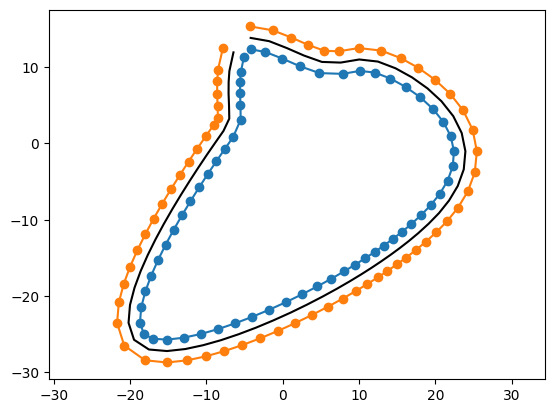

In [3]:
def generate_trajectory(c = 0.1, p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a trajectory which is a path through a Delaunay triangulation
        Respects global parameter `max_cone_dist`
        Also respects maximum curvature of the path
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Generate data
    N = 40
    x = np.random.uniform(0, 1, size=(N,2))

    # Filter points that are close to each other
    k = True
    I = np.arange(N)
    while k:
        k = False
        for i, j in enumerate(I):
            y = np.linalg.norm(x[j] - x[I], axis=1)
            y[i] = np.inf
            m = y < c

            if np.any(m):
                k = True
                I = I[~m]
                break
    x = x[I]

    # Create Delaunay triangulation
    simplices = Delaunay(x).simplices

    I = [ 0 ]
    S = set(I)
    T = { i: [] for i in range(N) }
    for i, j, k in simplices:
        T[i] += [ (i, j, k) ]
        T[j] += [ (i, j, k) ]
        T[k] += [ (i, j, k) ]

    # Find a path through the triangulation
    for _k in range(2 * int(np.sqrt(N))):
        i = I[-1]
        if _k < int(np.sqrt(N)):
            K = list(filter(lambda k: k not in S, chain(*T[i])))
        else:
            K = list(filter(lambda k: k not in S - set([ I[0] ]), chain(*T[i])))
        if not K:
            break
        if I[0] in K:
            I += [ I[0] ]
            break
        K = sorted(K, key=lambda k: -np.linalg.norm(x[k] - x[i]))
        k = K[-1]
        I += [ k ]
        S |= { k }
    x = x[I]

    # Smoothen the path
    X = CubicSpline(np.arange(len(x)), x, bc_type='periodic', axis=0)

    t = np.linspace(0, len(x) - 1, 200)
    x = X(t)

    while True:
        n = np.roll(x, 1, axis=0) - x
        n[0] = n[1]
        s = np.cumsum(np.linalg.norm(n, axis=1))
        dn = np.roll(n, 1, axis=0) - n
        dn[0] = dn[1]
        k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
        k_max = np.max(k)
        s_max = s[-1]

        if (s_max < 90) or (1.5 / min_cone_dist < k_max):
            x *= 1.1
        else:
            n = np.roll(x, 1, axis=0) - x
            n[0] = n[1]
            s = np.cumsum(np.linalg.norm(n, axis=1))
            dn = np.roll(n, 1, axis=0) - n
            dn[0] = dn[1]
            k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
            break

    return x, s, k

def generate_cones(p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a set of cones which are placed along a trajectory
        Respects global parameters `max_cone_dist` and `min_cone_dist`
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Find a trajectory which isn't too long, with not too step turns
    while True:
        try:
            x, s, k = generate_trajectory(c=0.005, p=p)
            if s[-1] < 300:
                break
        except:
            pass

    x = x - np.mean(x, axis=0)
    n = np.roll(x, 1, axis=0) - x; n[0] = n[1]; n /= np.linalg.norm(n, axis=1, keepdims=True)
    yaw = np.arctan2(n[:,1], n[:,0])

    # Find an interpolation which respects the maximum distance between cones
    S = np.cumsum(max_cone_dist * 1 / (min_cone_dist * k + 2))
    S = S[S < s[-1]]

    # Create dataset
    x = np.vstack((
        np.interp(S, s, x[:,0]),
        np.interp(S, s, x[:,1]),
    )).T
    n = np.vstack((
        np.interp(S, s, n[:,0]),
        np.interp(S, s, n[:,1]),
    )).T
    k = np.interp(S, s, k).reshape((-1, 1))
    y = np.interp(S, s, yaw)
    v = np.vstack((n[:,1], -n[:,0])).T
    p = k.copy()
    p[0] = p[1]
    p = 1 + 1 / (1 + 1000 * p)
    p = (p + np.roll(p, 1)) / 2
    p = (p + np.roll(p, 1)) / 2
    p = (p + np.roll(p, 1)) / 2
    p = 1
    l = x + min_cone_dist * v / 2  * p
    r = x - min_cone_dist * v / 2  * p

    return x, l, r, y

x, l, r, y = generate_cones(p = parameters)
dl = np.linalg.norm(np.diff(l, axis=0), axis=1)
dr = np.linalg.norm(np.diff(r, axis=0), axis=1)
print(np.min(dl), np.max(dl))
print(np.min(dr), np.max(dr))
plt.plot(x[:,0], x[:,1], 'k-')
plt.plot(l[:,0], l[:,1], 'o-')
plt.plot(r[:,0], r[:,1], 'o-')
plt.axis('equal')

(-29.410599827394538, 28.039266924533887, -54.4252514456348, 18.6511352225817)

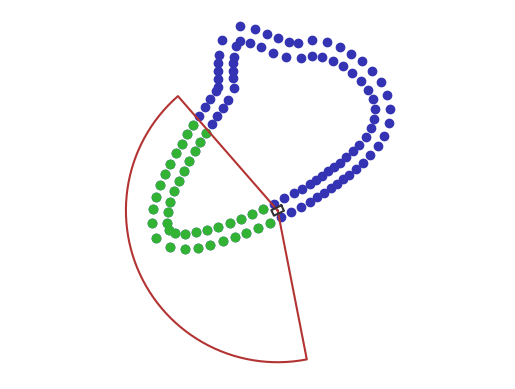

In [4]:
i = len(x) // 2
cones = homogenize(np.vstack((l, r)))
pose = np.array([ x[i, 0], x[i, 1], y[i] ])
visible_cones, I = get_visible_cones(cones, pose, p=parameters)

plot_cones(cones)
plot_cones(visible_cones, color=(0.2,0.7,0.2))
plot_fov(pose, p=parameters)
plot_car(pose, p=parameters)
plt.axis('equal')
plt.axis('off')

In [5]:
_m, _n = 1, 1
def points_in_track(y: np.ndarray((_m,3)), x: np.ndarray((_n,3)), p: dict = {}):
    threshold = p["min_cone_dist"]
    D = np.linalg.norm(y[:,:2].reshape((-1, 1, 2)) - x[:,:2].reshape((1, -1, 2)), axis=2)
    d = np.min(D, axis=1)
    return d < threshold

assert np.all(points_in_track(homogenize(x), homogenize(x), p=parameters))

In [6]:
def disturb_cones(cones: np.ndarray((_n, 3)), parameters: dict = {}):
    """
        Disturb the cones by a random amount
    """

    false_negative_rate = parameters["false_negative_rate"]
    false_positive_rate = parameters["false_positive_rate"]
    disturbed_cones = []
    for cone in cones:
        if np.random.uniform() < false_positive_rate:
            disturbed_cones += [ np.random.normal(np.array([0, 0, 0.4]), np.array([20, 20, 0])) ]
        else:
            disturbed_cones += [ cone + np.random.normal(np.array([0, 0, 0])) @ np.diag([0.1, 0.1, 0.05]) ]

    return np.array(disturbed_cones)

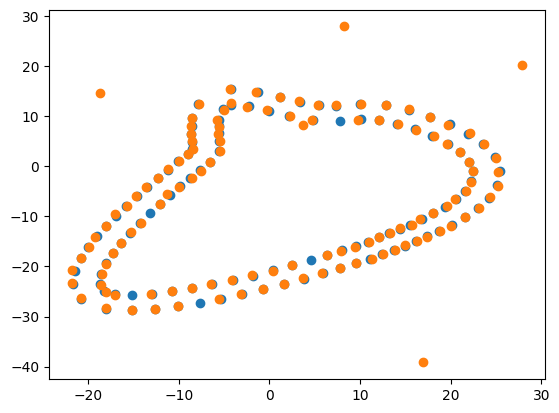

In [7]:
disturbed_cones = disturb_cones(cones, parameters)
plt.plot(cones[:,0], cones[:,1], 'o')
plt.plot(disturbed_cones[:,0], disturbed_cones[:,1], 'o')

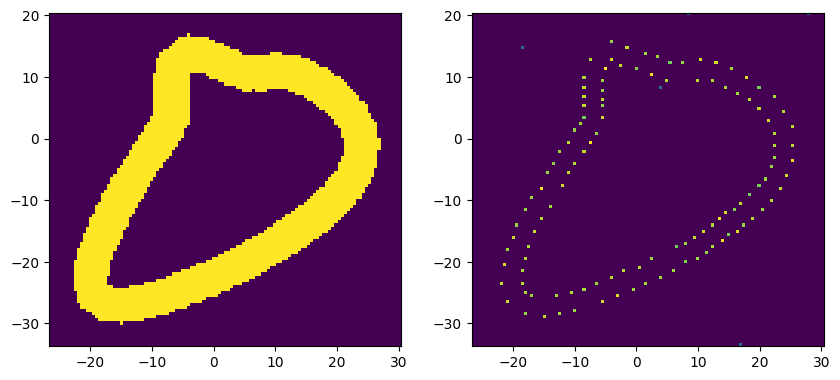

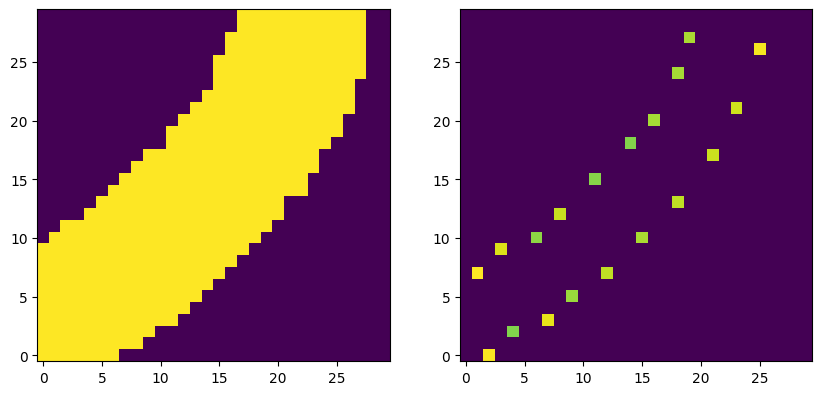

In [8]:
W = parameters['gW']
H = parameters['gH']
N = parameters['gN']
M = parameters['gM']
res = parameters['gRes']

w_min = np.min(cones[:,0]) - 5
w_max = np.max(cones[:,0]) + 5
h_min = np.min(cones[:,1]) - 5
h_max = np.max(cones[:,1]) + 5
w = np.arange(w_min, w_max, res)
_w = len(w)
h = np.arange(h_min, h_max, res)
_h = len(h)

def discretize(X: np.ndarray((_n, 3)), parameters: dict = {}):
    grid = np.zeros((_w, _h))
    X_d = np.vstack((
        np.clip((X[:, 0] - w_min) / (w_max - w_min) * _w, 0, _w - 1),
        np.clip((X[:, 1] - h_min) / (h_max - h_min) * _h, 0, _h - 1),
    )).T.astype(np.int32)
    grid[X_d[:,0], X_d[:,1]] = X[:, 2]
    return grid

X = np.array([ (i, j, 1) for i in w for j in h ])
m = points_in_track(X, homogenize(x), p=parameters)
facit = discretize(X[m])
meas = discretize(disturbed_cones)

ax1, ax2 = plt.subplots(1, 2, figsize=(10, 5))[1]
ax1.imshow(facit.T, origin='lower', extent=(w_min, w_max, h_min, h_max))
ax2.imshow(meas.T, origin='lower', extent=(w_min, w_max, h_min, h_max))
plt.show()

while True:
    i, j = np.random.choice(np.arange(_w - W)), np.random.choice(np.arange(_h - H))
    sfacit = facit[i:i+W,j:j+H]
    smeas = meas[i:i+W,j:j+H]

    if np.sum(sfacit) < 3:
        continue

    ax1, ax2 = plt.subplots(1, 2, figsize=(10, 5))[1]
    ax1.imshow(sfacit.T, origin='lower')
    ax2.imshow(smeas.T, origin='lower')
    plt.show()
    break

In [9]:
from concurrent.futures import ThreadPoolExecutor

N, M = parameters['gN'], parameters['gM']
K = N*M

measurements = np.zeros((N*M, W, H))
facits = np.zeros((N*M, W, H))

def process_n(n):
    x, l, r, y = generate_cones(p = parameters)
    cones = homogenize(np.vstack((l, r)))

    w_min = np.min(cones[:,0]) - 5
    w_max = np.max(cones[:,0]) + 5
    h_min = np.min(cones[:,1]) - 5
    h_max = np.max(cones[:,1]) + 5
    w = np.arange(w_min, w_max, res)
    _w = len(w)
    h = np.arange(h_min, h_max, res)
    _h = len(h)

    def discretize(X: np.ndarray((_n, 3)), parameters: dict = {}):
        grid = np.zeros((_w, _h))
        X_d = np.vstack((
            np.clip((X[:, 0] - w_min) / (w_max - w_min) * _w, 0, _w - 1),
            np.clip((X[:, 1] - h_min) / (h_max - h_min) * _h, 0, _h - 1),
        )).T.astype(np.int32)
        grid[X_d[:,0], X_d[:,1]] = X[:, 2]
        return grid

    X = np.array([ (i, j, 1) for i in w for j in h ])
    m = points_in_track(X, homogenize(x), p=parameters)
    facit = discretize(X[m])
    disturbed_cones = disturb_cones(cones, parameters)
    meas = discretize(disturbed_cones)

    for m in range(M):
        while True:
            i, j = np.random.choice(np.arange(_w - W)), np.random.choice(np.arange(_h - H))
            sfacit = facit[i:i+W,j:j+H]
            smeas = meas[i:i+W,j:j+H]

            if np.sum(sfacit) < 3:
                continue

            measurements[n*M+m] = smeas
            facits[n*M+m] = sfacit
            break


In [10]:
""" Create a convolutional neural network """
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, 3, padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.fc(x)

""" Train the network """
network = Network()

try:
    network.load_state_dict(torch.load('global_network.pth'))

except FileNotFoundError:
    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(process_n, range(N)), total=N))
    np.savez_compressed('global_data.npz', measurements=measurements, facits=facits)

    optimizer = optim.Adam(network.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    for epoch, b in enumerate(np.random.permutation(K)):
        x = torch.tensor(measurements[b]).float().reshape((1, 1, W, H))
        y = torch.tensor(facits[b]).float().reshape((1, 1, W, H))

        optimizer.zero_grad()
        y_hat = network(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        if epoch % int(np.sqrt(N*M)) == 0:
            print(epoch, loss.item())

    torch.save(network.state_dict(), 'global_network.pth')

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


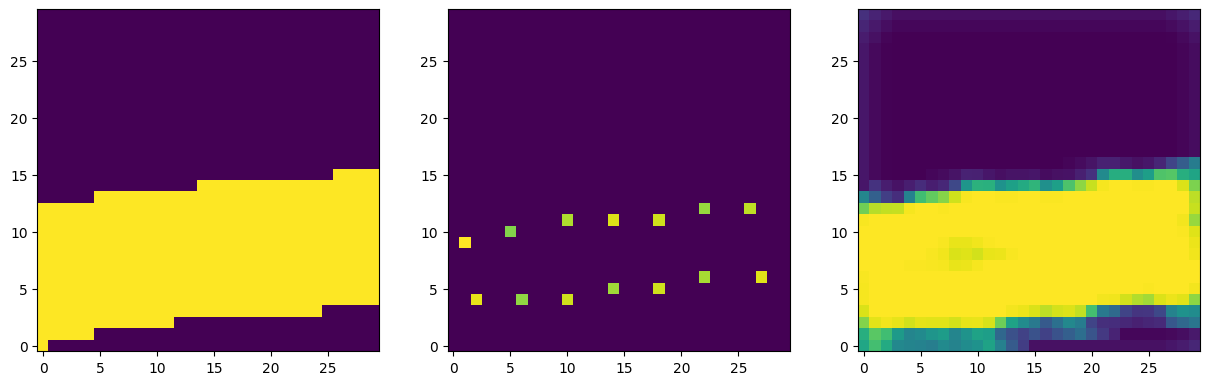

In [11]:
x, l, r, y = generate_cones(p = parameters)
cones = homogenize(np.vstack((l, r)))

w_min = np.min(cones[:,0]) - W
w_max = np.max(cones[:,0]) + W
h_min = np.min(cones[:,1]) - H
h_max = np.max(cones[:,1]) + H
w = np.arange(w_min, w_max, res)
_w = len(w)
h = np.arange(h_min, h_max, res)
_h = len(h)

def discretize(X: np.ndarray((_n, 3)), parameters: dict = {}):
    grid = np.zeros((_w, _h))
    X_d = np.vstack((
        np.clip((X[:, 0] - w_min) / (w_max - w_min) * _w, 0, _w - 1),
        np.clip((X[:, 1] - h_min) / (h_max - h_min) * _h, 0, _h - 1),
    )).T.astype(np.int32)
    grid[X_d[:,0], X_d[:,1]] = X[:, 2]
    return grid

X = np.array([ (i, j, 1) for i in w for j in h ])
m = points_in_track(X, homogenize(x), p=parameters)
facit = discretize(X[m])
disturbed_cones = disturb_cones(cones, parameters)
meas = discretize(disturbed_cones)

while True:
    i, j = np.random.choice(np.arange(_w - W)), np.random.choice(np.arange(_h - H))
    sfacit = facit[i:i+W,j:j+H]
    smeas = meas[i:i+W,j:j+H]

    if np.sum(sfacit) < 3:
        continue
    break

x = torch.tensor(smeas).float().reshape((1, 1, W, H))
y = torch.tensor(sfacit).float().reshape((1, 1, W, H))
y_hat = network(x)

ax1, ax2, ax3 = plt.subplots(1, 3, figsize=(15, 5))[1]
ax1.imshow(sfacit.T, origin='lower')
ax2.imshow(smeas.T, origin='lower')
ax3.imshow(y_hat.detach().numpy().reshape((W, H)).T, origin='lower')

In [12]:
_n, _m, _k = 1, 1, 1
_W, _H = 1, 1
def get_traj(pose: np.ndarray((3,)), landmarks: np.ndarray((_n,3)), grid: np.ndarray((_W,_H)), parameters: dict = parameters) -> np.ndarray((_k,3)):
    """ landmarks are all (hereto) visible cones """
    # create a set of points A which we know includes the centerline and the car pose
    if landmarks.shape[0] < 3:
        return I

    P = list(set(chain(*[ [ (i, j), (j, k), (k, i) ] for i, j, k in Delaunay(landmarks[:,:2]).simplices ])))
    A = np.array([ pose ] + [ (landmarks[i] + landmarks[j]) / 2 for i, j in P ])
    A_d = np.vstack((
        np.clip((A[:, 0] - w_min) / (w_max - w_min) * _w, 0, _w - 1),
        np.clip((A[:, 1] - h_min) / (h_max - h_min) * _h, 0, _h - 1),
    )).T.astype(np.int32)

    # create it's graph
    simplices = Delaunay(A[:,:2]).simplices
    D = { i: [] for i in range(len(A)) }
    V = dict()
    for i, j, k in simplices:
        V[(i, j)] = -(A[i, :2] - A[j, :2]) / np.linalg.norm(A[i, :2] - A[j, :2])**2
        V[(j, k)] = -(A[j, :2] - A[k, :2]) / np.linalg.norm(A[j, :2] - A[k, :2])**2
        V[(k, i)] = -(A[k, :2] - A[i, :2]) / np.linalg.norm(A[k, :2] - A[i, :2])**2
        D[i] += (i, j)
        D[j] += (j, k)
        D[k] += (k, i)

    # find a path through the graph by recursively finding the likeliest continuation
    def create_traj(I: list, vec: np.ndarray((2,))):
        # will select the next point which is close, ahead of the car, and has a high likelihood (close to center-line)
        # this is how we filter out corners
        i = I[-1]
        J = [ j for j in D[i] if not (j in I) ]
        if not J:
            return I
            
        proj = np.zeros((len(J),))
        for k, j in enumerate(J):
            _i, _j = A_d[j]
            proj[k] = np.dot(vec, V[(i, j)]) * grid[_i, _j]

        j = J[np.argmax(proj)]
        A[j, 2] = np.arctan2(A[j, 1] - A[i, 1], A[j, 0] - A[i, 0])
        return I if np.max(proj) < 0.15 else create_traj(I + [ j ], V[(i, j)])

    # create list of indices on the trajectory, starting at pose and moving forwards
    traj = create_traj([ 0 ], np.array([ np.cos(pose[2]), np.sin(pose[2]) ]))
    if len(traj) > 1:
        traj = traj[1:]
    if V.get((traj[-1], traj[0])) is not None:
        traj += [ traj[0] ]
    # returns points corresponding to the trajectory
    return (
        A[traj], # return points of the trajectory
        (traj[0] == traj[-1]) and (len(traj) > 20) # return whether the trajectory is a loop
    )

  4%|▍         | 13/320 [00:15<06:17,  1.23s/it]/tmp/ipykernel_121329/3464522530.py:77: RuntimeWarning: overflow encountered in exp
  grid = 1 - 1 / (1 + np.exp(belief))
100%|██████████| 320/320 [01:21<00:00,  3.93it/s]


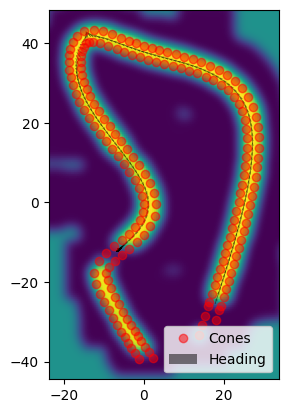

In [13]:
x, l, r, y = generate_cones(p = parameters)
cones = homogenize(np.vstack((l, r)))

res = 0.5
w_min = np.min(cones[:,0]) - W
w_max = np.max(cones[:,0]) + W
h_min = np.min(cones[:,1]) - H
h_max = np.max(cones[:,1]) + H
w = np.arange(w_min, w_max, res)
_w = len(w)
h = np.arange(h_min, h_max, res)
_h = len(h)

def discretize(X: np.ndarray((_n, 3)), parameters: dict = {}):
    grid = np.zeros((_w, _h))
    X_d = np.vstack((
        np.clip((X[:, 0] - w_min) / (w_max - w_min) * _w, 0, _w - 1),
        np.clip((X[:, 1] - h_min) / (h_max - h_min) * _h, 0, _h - 1),
    )).T.astype(np.int32)
    grid[X_d[:,0], X_d[:,1]] = X[:, 2]
    return grid

""" Create landmarks and belief """
belief = np.zeros((_w, _h))
# prior: everything within d of origin is definetely occupied
d = parameters['min_cone_dist']
prior = 0.5 * np.ones((_w, _h))
#prior[(w.reshape((-1, 1)) - 0)**2 + (h.reshape((1, -1)) - 0)**2 < d**2] = 1 - 1e-6

landmarks = []
counts = []

""" Loop """
i = len(x) - 1
pose = np.array([ x[i, 0], x[i, 1], y[i] ])
poses = [ pose ]
traj = np.zeros((1, 3))

""" Animation """
Poses = []
Trajs = []
Landmarks = []
Grids = []

C = 320
for k in tqdm(range(C)):
    """ Get measurement """
    # get discretized measurement in m frame
    _, new_landmarks = get_visible_cones(cones, pose, p=parameters)
    landmarks = list(set(landmarks + new_landmarks))
    counts = counts + [ 0 for _ in range(len(landmarks) - len(counts)) ]

    # get discretized reconstruction in m frame
    disturbed_cones = disturb_cones(cones, parameters=parameters)
    measurement = discretize(disturbed_cones[landmarks])

    """ Update belief """
    scan = []
    if np.any([count == 0 for count in counts]):
        p = 1 / (np.array(counts) + 1e-6)
        p /= np.sum(p)
        indices = np.random.choice(list(range(len(landmarks))), replace=False, size=12, p=p)
        for index in indices:
            scan += [ disturbed_cones[landmarks[index]] ]
            counts[index] += 1

    for landmark in scan:
        i, j = np.clip((landmark[0] - w_min) / (w_max - w_min) * _w, 0, _w - 1), np.clip((landmark[1] - h_min) / (h_max - h_min) * _h, 0, _h - 1)
        i = np.clip(np.arange(i - W // 2, i + W // 2).astype(np.int32).reshape((-1, 1))[:30, :], 0, _w - 1)
        j = np.clip(np.arange(j - H // 2, j + H // 2).astype(np.int32).reshape((1, -1))[:, :30], 0, _h - 1)
        x = torch.tensor(measurement[i, j]).float().reshape((1, 1, W, H))
        p = network(x).detach().numpy().reshape((W, H))
        p[1:-1, 1:-1] = (p[1:-1, 1:-1] + p[:-2, 1:-1] + p[2:, 1:-1] + p[1:-1, :-2] + p[1:-1, 2:]) / 5
        p = np.clip(p, 1e-6, 1 - 1e-6)

        belief[i, j] = belief[i, j] + np.log(p / (1 - p)) - np.log(prior[i, j] / (1 - prior[i, j]))
        grid = 1 - 1 / (1 + np.exp(belief))

        for _ in range(10):
            grid = (grid + np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0)) / 3
            grid = (grid + np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1)) / 3
    
    """ Move """
    # get likeliest path in g frame
    old_traj = traj.copy()
    new_traj, loop = get_traj(poses[0], cones[landmarks], grid, parameters=parameters)
    #if loop:
    #    print("loop !")
    #    break
    traj = new_traj if len(new_traj) >= len(old_traj) else old_traj

    closest = np.argmin(np.linalg.norm(traj[:, :2] - pose[:2], axis=1))
    goal = traj[np.clip(closest + 3, 0, len(traj) - 1)]

    pose = np.array([
        0.7 * pose[0] + 0.3 * goal[0],
        0.7 * pose[1] + 0.3 * goal[1],
        pose[2] + 0.5 * np.sin((goal[2] - pose[2]) / 2),
    ])
    poses += [ pose ]

    """ Plot """
    Poses += [ np.array(poses).copy() ]
    Trajs += [ traj.copy() ]
    Landmarks += [ disturbed_cones[landmarks].copy() ]
    Grids += [ grid.copy() ]

plt.plot(cones[landmarks,0], cones[landmarks,1], 'or', label='Cones', alpha=0.5)
poses = np.array(poses)
#plt.plot(traj[:,0], traj[:,1], 'o-', label='Trajectory', alpha=1.0)
#plt.plot(poses[:, 0], poses[:, 1], 'o-', label='Poses', alpha=0.5)
plt.quiver(poses[:, 0], poses[:, 1], np.cos(poses[:, 2]), np.sin(poses[:, 2]), label='Heading', alpha=0.5)
plt.imshow(grid.T, extent=[w_min, w_max, h_min, h_max], origin='lower')
plt.legend()

x_min = np.min(cones[landmarks,0]) - 5
x_max = np.max(cones[landmarks,0]) + 5
y_min = np.min(cones[landmarks,1]) - 5
y_max = np.max(cones[landmarks,1]) + 5
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()